# Postprocessing

This notebook illustrates the effect of our post-processing steps.
#### Structure
- **Global parameters**   *Adapt this section if you run this code not in the repository.*
- **Basic functionality** *This section has basic functionality and imports.*
- **Removal of small regions** *Our first post-processing method which is used later on.*
- **Hough Transform** *We illustrate how we use the Hough-Transform*
    - Illustration of Hough Lines
    - First optimization using Hough Lines as a probability booser
    - Second optimization using Hough Lines by setting them as a region

**Please look in each cell that displays images for parameters to adapt and see the effects of varying parameters**

## Global parameters
Please adapt this parameters.
no_displayed is how many images you want to see when looking at images.

In [1]:
dir_images = '../data/test/images/'
dir_cont_masks = '../data/test/results/'

no_displayed = 5

## Basic functionality
Basic function for loading, storing and displaying

In [12]:
import numpy as np
import os
import cv2
import skimage
import skimage.io as io
from skimage import img_as_ubyte, measure, filters
import matplotlib.pyplot as plt
import maxflow

def load_images():
    image_names = os.listdir(dir_images)
    images = []
    for name in image_names:
        images.append(cv2.imread(dir_images + name))
    mask_names = os.listdir(dir_images)
    masks = []
    for name in image_names:
        x = cv2.imread(dir_cont_masks + name, cv2.IMREAD_GRAYSCALE)/255
        masks.append(x)
    return images, masks

def save_images(masks, save_dir):
    image_names = os.listdir(dir_images)
    for i in range(len(image_names)):
        io.imsave(os.path.join(save_dir, image_names[i]), img_as_ubyte(masks[i]))

def display(all_images, names=None, rows=94):
    image_names = os.listdir(dir_images)
    columns = len(all_images)
    
    #fig.tight_layout()
    
    for i in range(0, rows):
        fig = plt.figure(figsize = (15,15./columns))
        for j in range(0, columns):
            fig.add_subplot(1, columns, j+1)
            plt.imshow(all_images[j][i])
            plt.axis('off')
            title = image_names[i]
            if names != None and columns == len(names):
                title = title + ' ' + names[j]
            plt.title(title)
        plt.show()
    
def discretize(masks, eps=0.5):
    res = []
    for mask in masks:
        mask_c = mask.copy()
        mask_c[mask_c > eps] = 1.0
        mask_c[mask_c <= eps] = 0.0
        res.append(mask_c)

    return res

## Removal of small regions

Function to remove small regions in a segmentation on a list of masks.

In [3]:
def remove_small_regions(mask, no_pixels=256):
        mres = mask.copy()
        all_labels = measure.label(mres)

        mres = measure.label(mres, background=0)
        uniq = np.unique(mres, return_counts=True)
        labs = uniq[0]
        cnts = uniq[1]

        for i, lab in enumerate(labs):
            if cnts[i] < no_pixels:
                mres[np.where(mres==lab)] = 0
                
        mres[np.where(mres != 0)] = 1
        return mres.astype('float32')

def remove_small_regions_masks_list(masks, no_pixels=256):
    res = []
    for mask in masks:
        res.append(remove_small_regions(mask, no_pixels))
    return res

This looks as follows

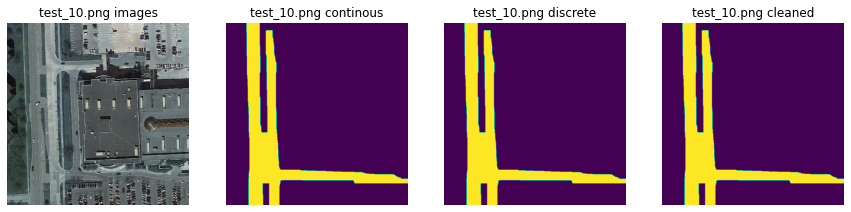

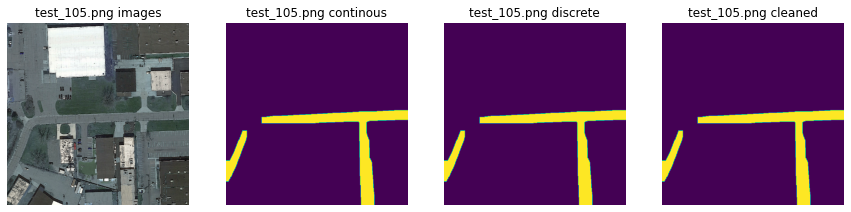

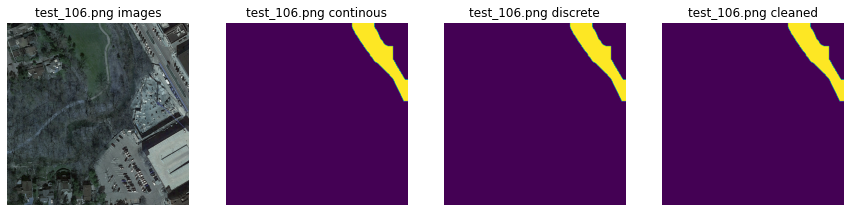

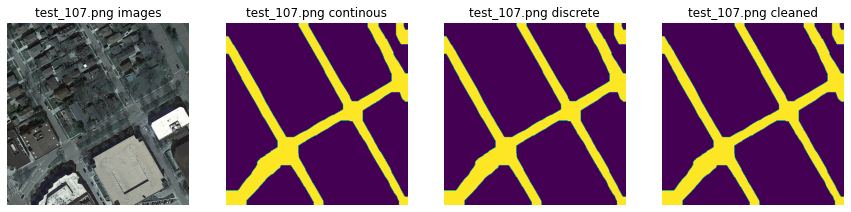

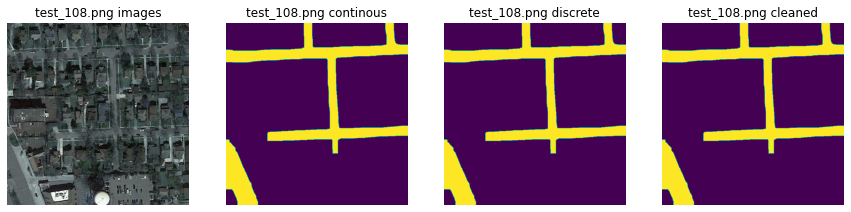

In [4]:
MIN_REGION_SIZE = 32**2 # Adapt this parameter

images, masks = load_images()
disc_masks = discretize(masks)
cleaned_masks = remove_small_regions_masks_list(disc_masks, MIN_REGION_SIZE)

display([images, masks, disc_masks, cleaned_masks],
        names=['images', 'continous', 'discrete', 'cleaned'],
        rows = no_displayed)

## Hough Transform / Connect unconneced regions

### Extract Hough Transform Lines into a numpy array

Create Hough Transforms and stores how often a pixel is hit by a Hough Line.
We use the previously shown region after the Hough transform.

In [5]:
def get_hough_lines(mask, threshold, min_line_length, max_line_gap):
        gray = (mask*255).astype('uint8')
        lines = cv2.HoughLinesP(gray,1,np.pi/180,threshold,minLineLength=min_line_length,maxLineGap=max_line_gap)

        hough_lines = np.zeros(gray.shape)
        if not lines is None:   
            for x in range(0, len(lines)):
                for x1,y1,x2,y2 in lines[x]:
                    one_hough = np.zeros(gray.shape[0:2])
                    cv2.line(one_hough,(x1,y1),(x2,y2), 1., 1)
                    hough_lines = hough_lines + one_hough

        return hough_lines
    
def get_hough_lines_masks_list(disc_masks, threshold, min_line_length, max_line_gap):
    houghs = []
    for mask in disc_masks:
        houghs.append(get_hough_lines(mask, threshold, min_line_length, max_line_gap))
    return houghs

### Illustration of Hough Lines
See how Hough Lines look

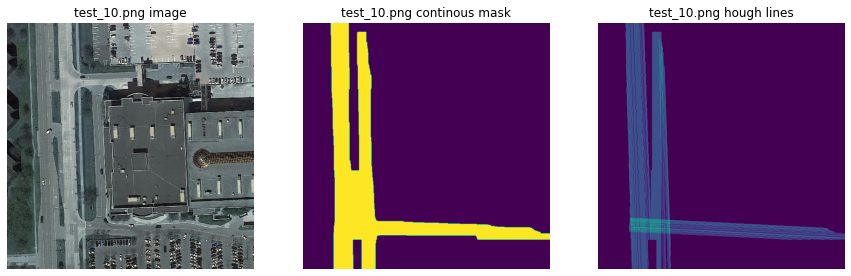

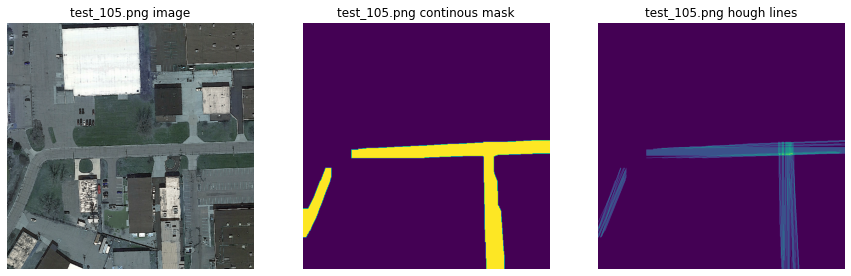

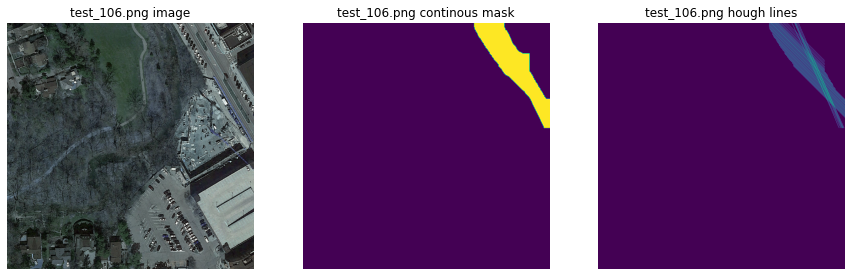

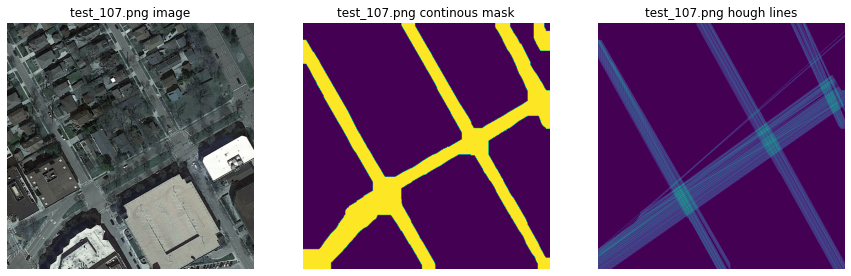

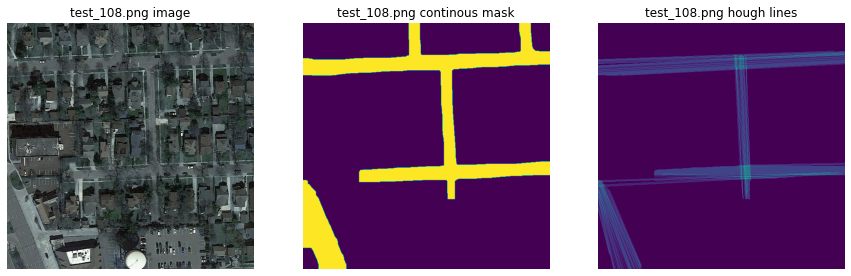

In [6]:
THRESHOLD = 100 # Adapt this parameter
MIN_LINE_LENGTH = 1 # Adapt this parameter
MAX_LINE_GAP = 500 # Adapt this parameter

images, masks = load_images()
disc_masks = discretize(masks)
houghs = get_hough_lines_masks_list(disc_masks, THRESHOLD, MIN_LINE_LENGTH, MAX_LINE_GAP)
display([images, masks, houghs],
        names = ['image', 'continous mask', 'hough lines'],
        rows=no_displayed)

### Increase probability on continous mask by a constant factor

This section adds 'EPS' to the probability mask on pixels through which at least 'THRESH' lines go through.
#### Effect on continous mask

In [7]:
def hough_update_mask(mask, hough_lines, thresh, eps, kernel=np.ones((3,3),np.uint8)):
    updated_mask = mask.copy()
    hough_lines_c = hough_lines.copy()
    if not kernel is None:
        hough_lines_c = cv2.morphologyEx(hough_lines_c, cv2.MORPH_CLOSE, kernel)
    updated_mask = updated_mask + eps * (hough_lines_c >= thresh)
    return updated_mask

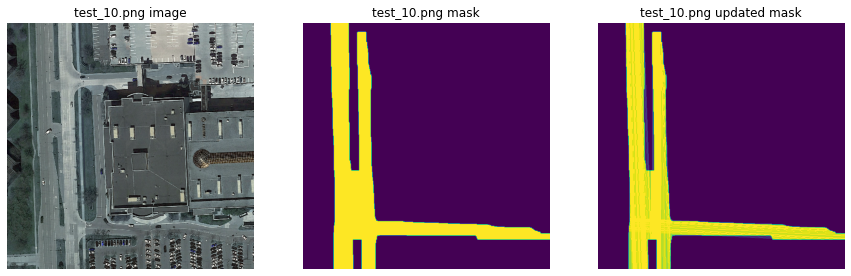

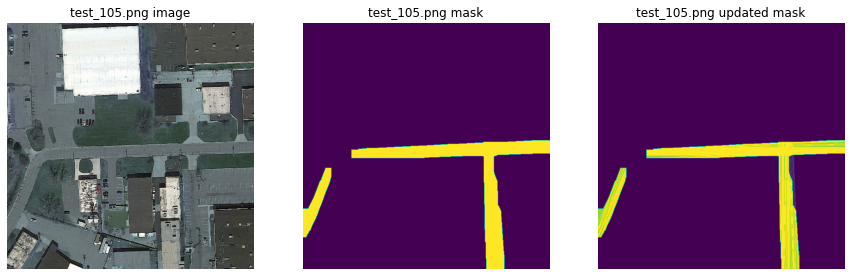

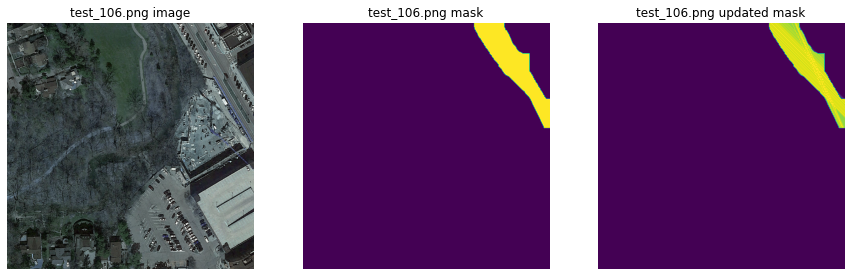

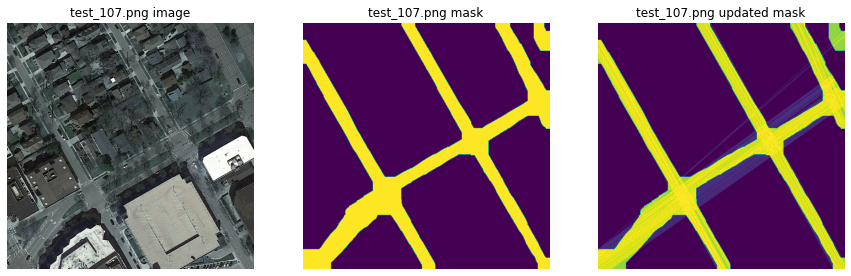

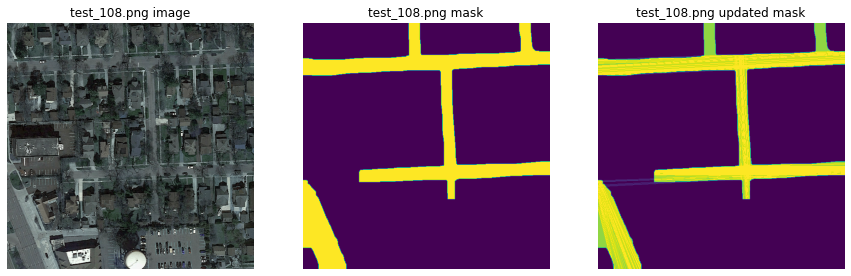

In [8]:
THRESHOLD = 100 # Adapt this parameter
MIN_LINE_LENGTH = 1 # Adapt this parameter
MAX_LINE_GAP = 500 # Adapt this parameter

THRESH = 1 # How many lines need to go through pixel to increase its probability (Adapt this parameter)
EPS = 0.2 # How much do you want to add to a pixel if a line hits it (Adapt this parameter)

images, masks = load_images()
disc_masks = discretize(masks)
houghs = get_hough_lines_masks_list(disc_masks, THRESHOLD, MIN_LINE_LENGTH, MAX_LINE_GAP)

# Update the continous mask with EPS
updated_masks = []
for i in range(len(masks)):
    updated_masks.append(hough_update_mask(masks[i], houghs[i], THRESH, EPS, None))
    
display([images, masks, updated_masks],
        names=['image', 'mask', 'updated mask'],
        rows=no_displayed)

#### Show effect on discretized mask

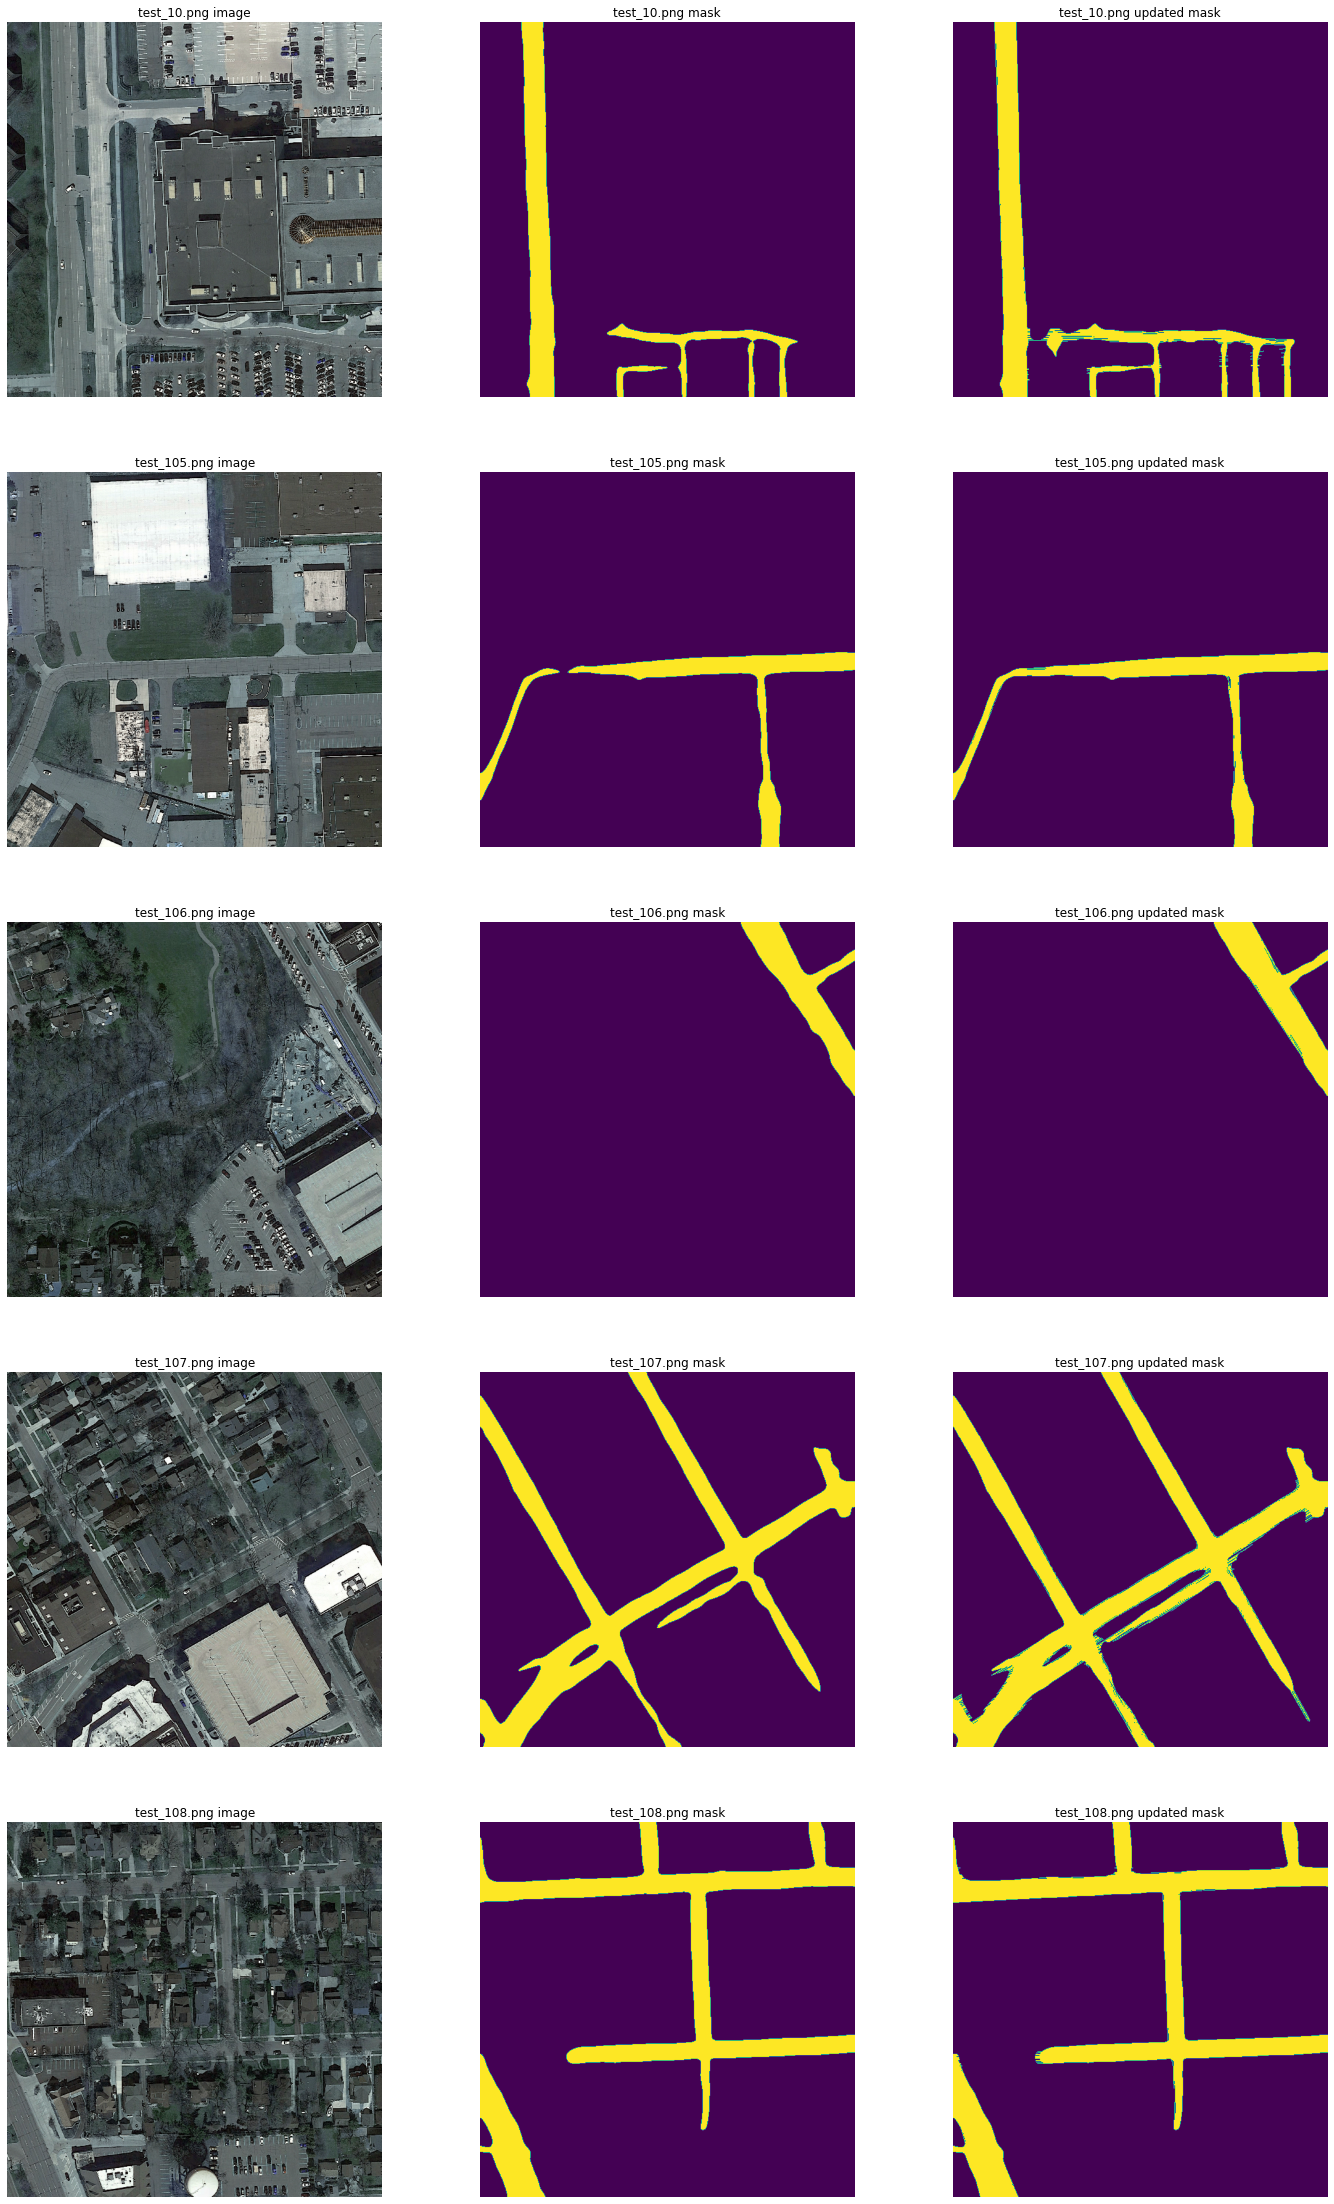

In [9]:
THRESHOLD = 100 # Adapt this parameter
MIN_LINE_LENGTH = 1 # Adapt this parameter
MAX_LINE_GAP = 500 # Adapt this parameter

THRESH = 1 # How many lines need to go through pixel to increase its probability (Adapt this parameter)
EPS = 0.2 # How much do you want to add to a pixel if a line hits it (Adapt this parameter)

MIN_REGION_SIZE = 32**2 # Adapt this parameter

images, masks = load_images()
disc_masks = discretize(masks)
houghs = get_hough_lines_masks_list(disc_masks, THRESHOLD, MIN_LINE_LENGTH, MAX_LINE_GAP)

# Update the continous mask with EPS
updated_masks = []
for i in range(len(masks)):
    updated_masks.append(hough_update_mask(masks[i], houghs[i], THRESH, EPS, None))

# Discretize the continous masks
disc_masks = discretize(masks)
disc_updated_masks = discretize(updated_masks)

# Clean-up artifacts with region removal
clean_disc_masks = remove_small_regions_masks_list(disc_masks, MIN_REGION_SIZE)
clean_disc_updated_masks = remove_small_regions_masks_list(disc_updated_masks, MIN_REGION_SIZE)

display([images, clean_disc_masks,clean_disc_updated_masks],
        names=['image', 'mask', 'updated mask'],
        rows=no_displayed)

### Final step: Closing on Hough Lines to get smoother results
In this section we get the Hough lines and apply morphological closing on those.
Using this closed mask, we proceed as before.

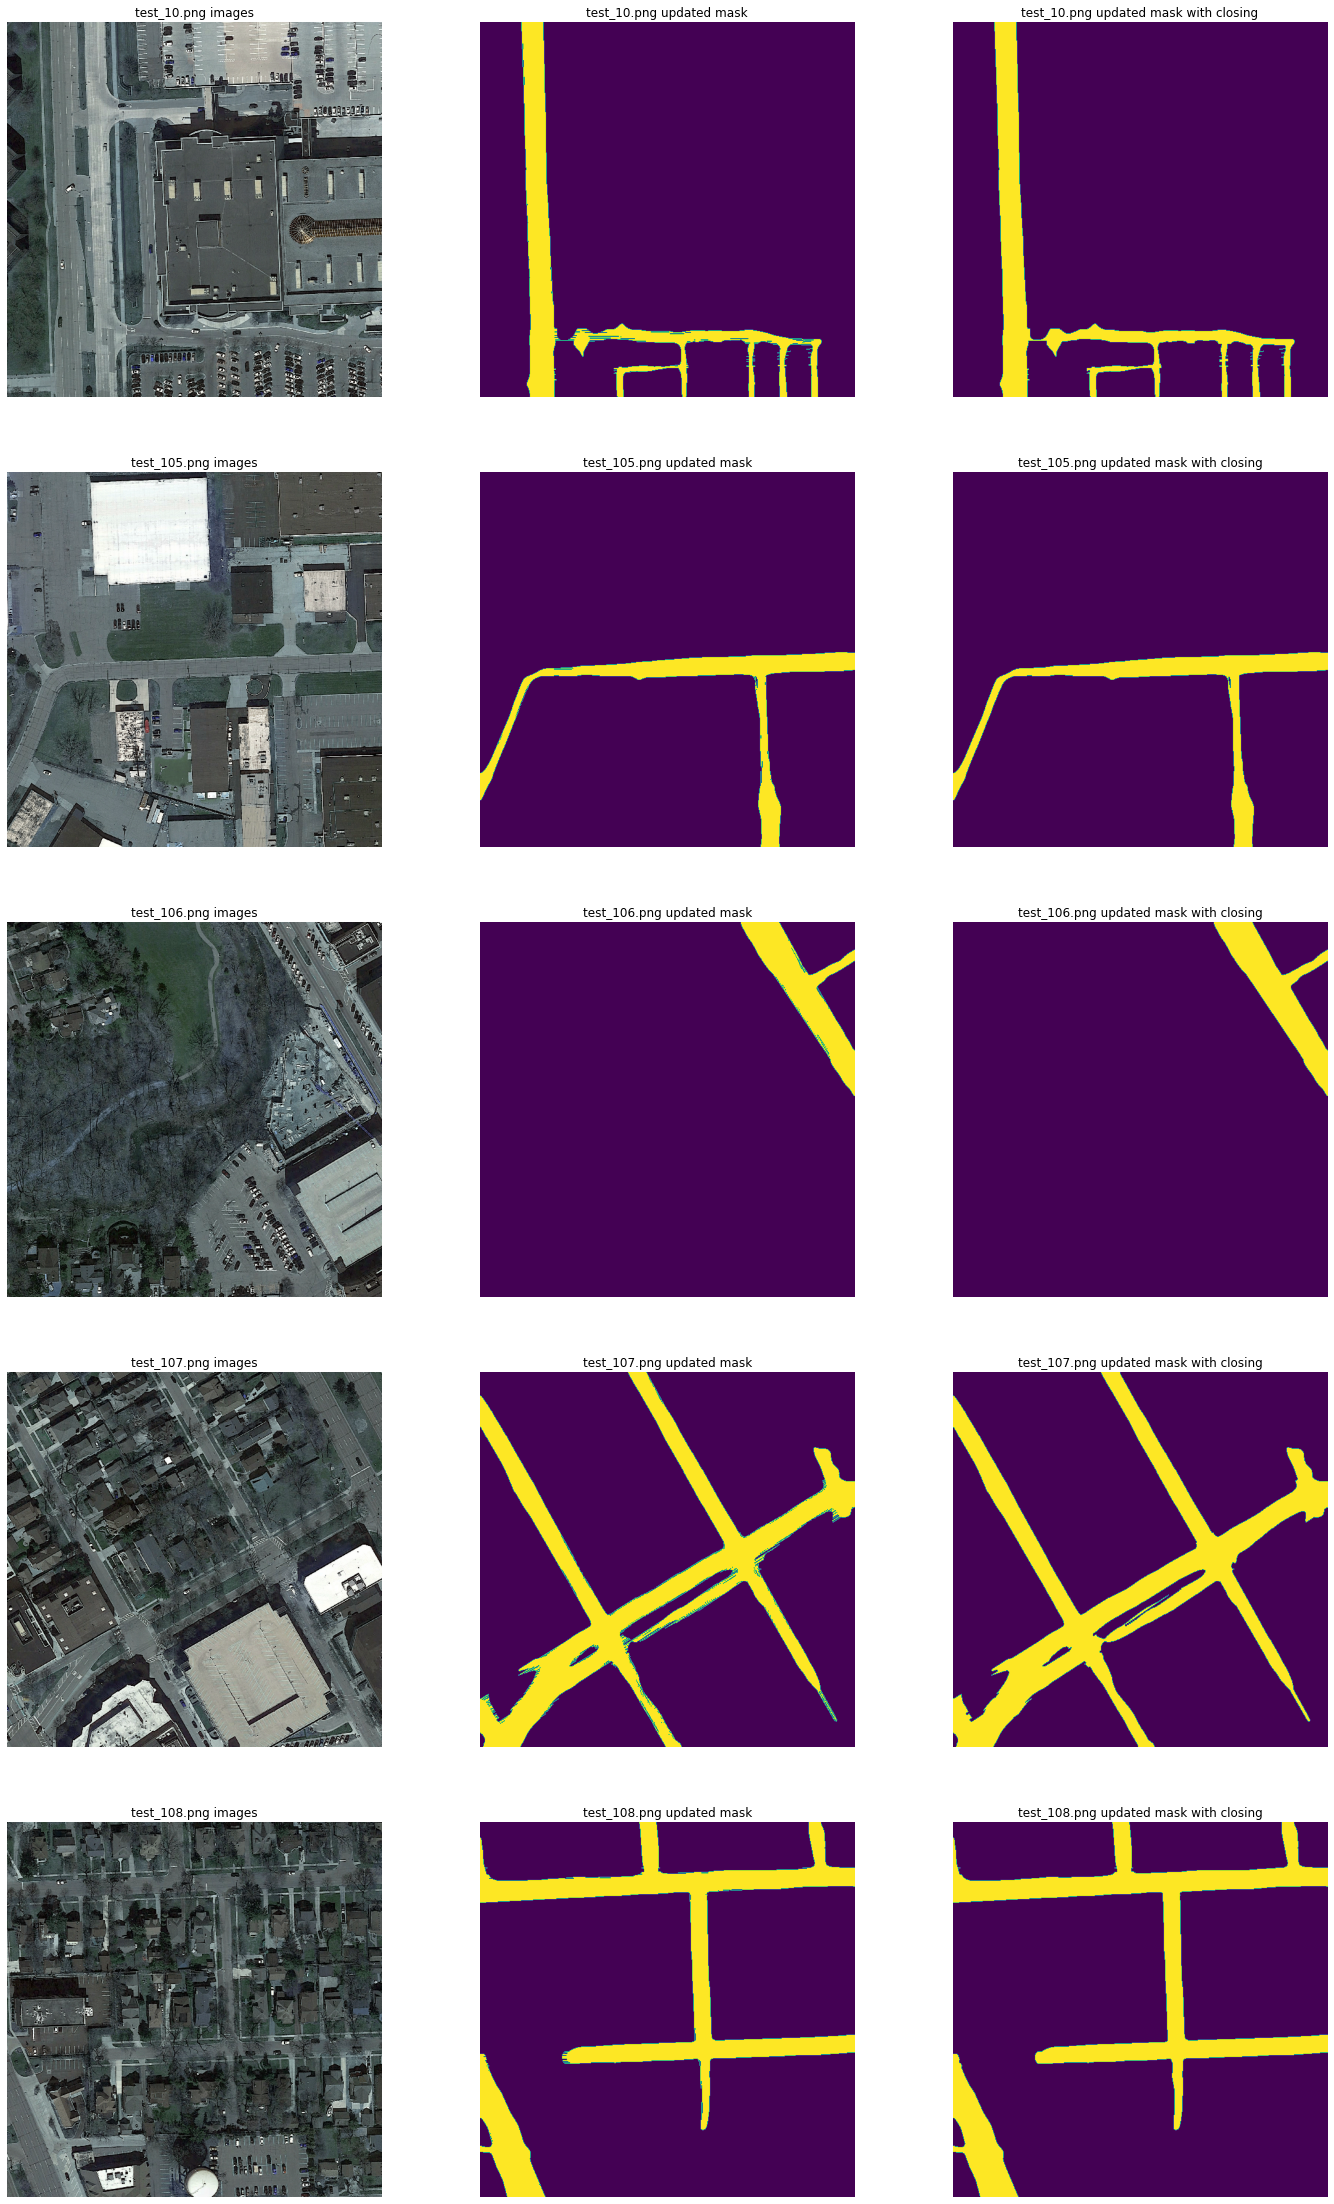

In [10]:
THRESHOLD = 100 # Adapt this parameter
MIN_LINE_LENGTH = 1 # Adapt this parameter
MAX_LINE_GAP = 500 # Adapt this parameter
THRESH = 1 # How many lines need to go through pixel to increase its probability (Adapt this parameter)
EPS = 0.2 # How much do you want to add to a pixel if a line hits it (Adapt this parameter)
MIN_REGION_SIZE = 32**2 # Adapt this parameter
kernel = np.ones((3,3),np.uint8) # Adapt this parameter

images, masks = load_images()
disc_masks = discretize(masks)
houghs = get_hough_lines_masks_list(disc_masks, THRESHOLD, MIN_LINE_LENGTH, MAX_LINE_GAP)

# Update the continous mask with EPS
updated_masks = []
for i in range(len(masks)):
    updated_masks.append(hough_update_mask(masks[i], houghs[i], THRESH, EPS, None))
updated_masks_closed = []
for i in range(len(masks)):  
    updated_masks_closed.append(hough_update_mask(masks[i], houghs[i], THRESH, EPS, kernel))
    

# Discretize the continous masks
disc_updated_masks = discretize(updated_masks)
clean_disc_updated_masks = remove_small_regions_masks_list(disc_updated_masks, MIN_REGION_SIZE)
disc_updated_masks_closed = discretize(updated_masks_closed)
clean_disc_updated_masks_closed = remove_small_regions_masks_list(disc_updated_masks_closed, MIN_REGION_SIZE)

display([images, clean_disc_updated_masks, clean_disc_updated_masks_closed],
       names=['images', 'updated mask', 'updated mask with closing'],
       rows=no_displayed)

### Summarized
For each mask, discretize and get Hough Lines using get_hough_lines
Update continous mask using hough_update_mask. Set the kernel carefully.

Pass the updated continous to another step or discretize and perform the cleanup using remove_small_regions

## Graph cut

In this section we can explore the effect of the graph cut

We preprocess the colored test images by transforming them to the LAB color space and apply a gaussian filter

In [13]:
def adjust_image_for_graphcut(img):
    img = skimage.color.rgb2lab(img)
    img = filters.gaussian(img, sigma=1, multichannel=True)
    if np.max(img) > 1.0:
        img = img / 255.0
    return img


def graph_cut(prediction, img, lambda_, sigma):
    img = adjust_image_for_graphcut(img)

    g = maxflow.Graph[float]()
    nodeids = g.add_grid_nodes(prediction.shape)

    structure = np.array( [[0, 0, 0],
                           [0, 0, 1],
                           [0, 0, 0]])

    img_right = np.roll(img, 1, axis=2)
    weights = img - img_right
    weights = np.multiply(weights, weights)
    weights = weights[:,:,0] + weights[:,:,1] + weights[:,:,2]

    weights = weights / (2 * sigma * sigma)
    weights = np.exp(-weights)

    g.add_grid_edges(nodeids, weights=lambda_ * weights, structure=structure, symmetric=True)

    structure = np.array([[0, 0, 0],
                          [0, 0, 0],
                          [0, 1, 0]])

    img_down = np.rot90(img)
    img_down = np.roll(img_down, 1, axis=2)
    img_down = np.rot90(img_down, k=-1)
    weights = img - img_down
    weights = np.multiply(weights, weights)
    weights = weights[:, :, 0] + weights[:, :, 1] + weights[:, :, 2]

    weights = weights / (2 * sigma * sigma)
    weights = np.exp(-weights)

    g.add_grid_edges(nodeids, weights=lambda_ * weights, structure=structure, symmetric=True)

    g.add_grid_tedges(nodeids, prediction, 1 - prediction)

    g.maxflow()
    sgm = g.get_grid_segments(nodeids)
    result = np.int_(np.logical_not(sgm))
    result *= 255
    return result

### Show effect of graph c

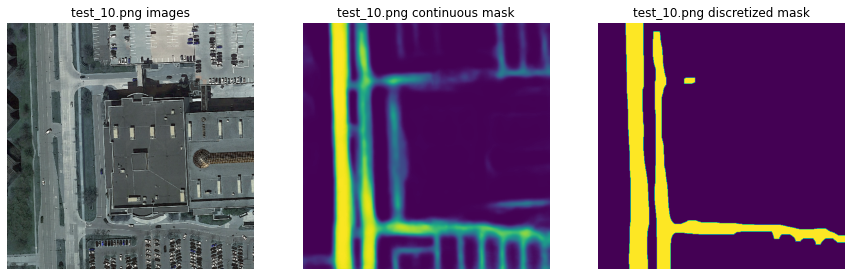

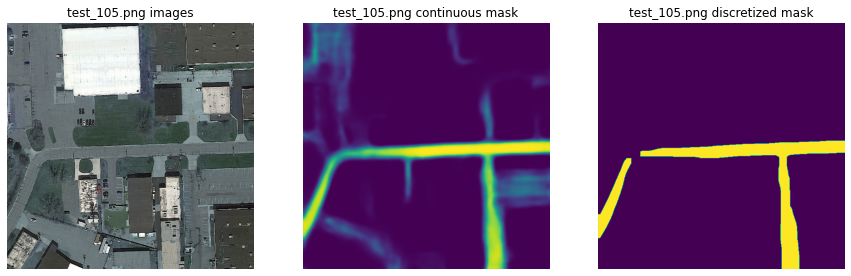

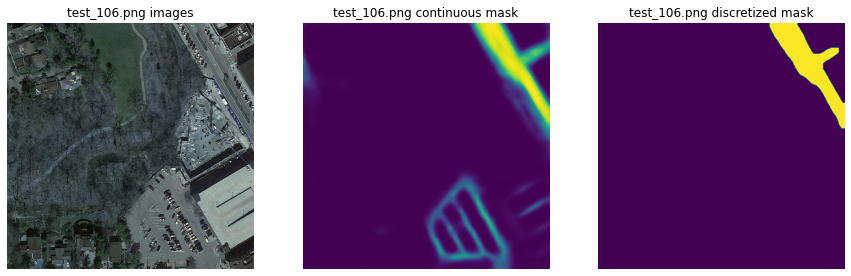

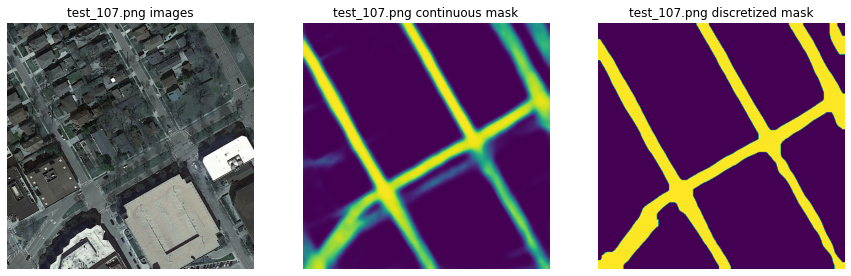

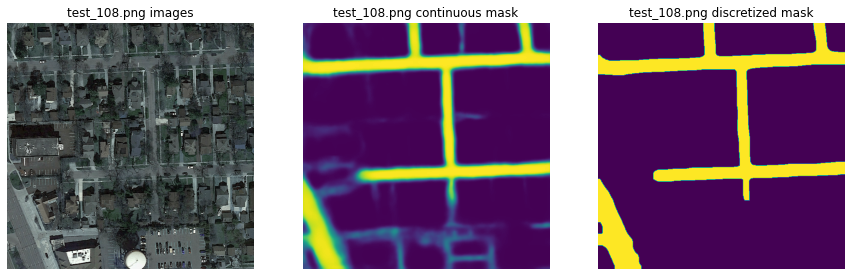

In [17]:
LAMBDA = 1 # Adapt this parameter
SIGMA = 3 # Adapt this parameter

images, masks_cont = load_images()

masks_disc = []
for i in range(len(images)):
    mask_disc = graph_cut(masks_cont[i], images[i], LAMBDA, SIGMA)
    masks_disc.append(mask_disc)

    
display([images, masks_cont, masks_disc],
       names=['images', 'continuous mask', 'discretized mask'],
       rows=no_displayed)